<a href="https://colab.research.google.com/github/kcaat/datathon4/blob/main/Datathon_4_Team_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install --upgrade category_encoders

# Data Engineering

In [3]:
#!pip install category_encoders

import pandas as pd
import io
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
# # Uploading the Data
#from google.colab import files
#uploaded = files.upload()

Saving datathon4.csv to datathon4.csv


In [5]:
# Read the dataset into a Pandas DataFrame with specified encoding
df = pd.read_csv("datathon4.csv")
df_dict = pd.read_csv("datathon4-dictionary.csv")
# Display the first few rows of the dataset to ensure it's loaded correctly
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
#number of unique patients vs encounters
print(df['patient_id'].nunique())
print(df['encounter_id'].nunique())

91713
91713


# Variable Selections
**Use the original dataset to select binary categorical variables and numerical variables**

In [6]:
from pickle import TRUE

# Check the correlation for non-string variables
bi_num_data = df.select_dtypes(include=['float64', 'int64'])
correlation = bi_num_data.corr().abs()

# Get the upper correlation values
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
upper

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
encounter_id,NaN,0.009575,0.004532,0.005243,0.003990,0.001068,0.002036,0.005400,0.000992,0.000570,...,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646
patient_id,NaN,NaN,0.007075,0.004877,0.006343,0.001380,0.001387,0.002902,0.001770,0.004412,...,0.003735,0.001625,0.002426,0.001307,0.000434,0.001667,0.000548,0.000844,0.002333,0.003065
hospital_id,NaN,NaN,NaN,0.001255,0.008673,0.012874,0.052123,0.027895,0.004526,0.001285,...,0.006993,0.000283,0.004947,0.002962,0.011978,0.001362,0.000146,0.002992,0.002588,0.004730
hospital_death,NaN,NaN,NaN,NaN,0.111017,0.031247,0.093574,0.019526,0.000994,0.063316,...,0.311043,0.283913,0.004403,0.039453,0.015784,0.038864,0.043973,0.029788,0.018722,0.051105
age,NaN,NaN,NaN,NaN,NaN,0.087077,0.067320,0.109937,0.024257,0.049872,...,0.143167,0.076275,0.029477,0.028065,0.077908,0.020061,0.025007,0.030310,0.023335,0.025924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hepatic_failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003084,0.001567,0.001689,0.007240
immunosuppression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134934,0.103201,0.269653
leukemia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031380,0.006210
lymphoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014749


In [7]:
# Use heatmap to see variables that are highly related to the outcome variable 'hospital_death'
high_corr_var = correlation['hospital_death'][correlation['hospital_death'] > 0.2].index.tolist()
high_corr_var

['hospital_death',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'ph_apache',
 'ventilated_apache',
 'd1_mbp_invasive_min',
 'd1_spo2_min',
 'd1_sysbp_invasive_min',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_min',
 'd1_temp_min',
 'd1_albumin_min',
 'd1_lactate_max',
 'd1_lactate_min',
 'h1_albumin_max',
 'h1_albumin_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'd1_arterial_ph_min',
 'h1_arterial_ph_max',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob']

In [8]:
# Checking for missing values
missing_count = df[high_corr_var].isnull().sum()
print(missing_count)

hospital_death                       0
fio2_apache                      70868
gcs_eyes_apache                   1901
gcs_motor_apache                  1901
gcs_verbal_apache                 1901
ph_apache                        70868
ventilated_apache                  715
d1_mbp_invasive_min              67777
d1_spo2_min                        333
d1_sysbp_invasive_min            67959
d1_sysbp_min                       159
d1_sysbp_noninvasive_min          1027
d1_temp_min                       2324
d1_albumin_min                   49096
d1_lactate_max                   68396
d1_lactate_min                   68396
h1_albumin_max                   83824
h1_albumin_min                   83824
h1_lactate_max                   84369
h1_lactate_min                   84369
d1_arterial_ph_min               60123
h1_arterial_ph_max               76424
apache_4a_hospital_death_prob     7947
apache_4a_icu_death_prob          7947
dtype: int64


In [9]:
high_corr_selected = []
for i in high_corr_var:
  if missing_count[i] < 0.1*len(df):
    high_corr_selected.append(i)

print(high_corr_selected)
len(high_corr_selected)

['hospital_death', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'ventilated_apache', 'd1_spo2_min', 'd1_sysbp_min', 'd1_sysbp_noninvasive_min', 'd1_temp_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']


11

In [10]:
# Manually select the features we are interested in
# manu_feat_selected = ['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_spo2_max', 'd1_spo2_min', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
manu_feat_selected = ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']
feat_selected = list(set(manu_feat_selected) | set(high_corr_selected))

# Drop 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' because they are calculated based on 'hospital_dealth'
feat_selected.remove('apache_4a_hospital_death_prob')
feat_selected.remove('apache_4a_icu_death_prob')
print(feat_selected)
len(feat_selected)

['d1_spo2_min', 'ethnicity', 'apache_2_bodysystem', 'gcs_motor_apache', 'gcs_verbal_apache', 'd1_temp_min', 'icu_stay_type', 'd1_sysbp_min', 'hospital_death', 'ventilated_apache', 'gcs_eyes_apache', 'icu_type', 'gender', 'icu_admit_source', 'd1_sysbp_noninvasive_min', 'apache_3j_bodysystem']


16

In [11]:
df_selected=df[feat_selected]

# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

categorical_columns = []

for i in df_selected:
  x= df_dict.at[df_dict['Variable Name'].eq(i).idxmax(), 'Data Type']
  if x == 'binary' or x == 'string':
    categorical_columns.append(i)
categorical_columns.remove(target_column)


# # List of columns that contain numerical data
numerical_columns = [c for c in df_selected.columns if c not in categorical_columns and c != target_column]
print(categorical_columns)
print(numerical_columns)
df.head()

#view unique values for categorical variables
for variable in categorical_columns:
    unique_values = df[variable].unique()
    print(f"Unique values for {variable}:")
    print(unique_values)
    print()

['ethnicity', 'apache_2_bodysystem', 'icu_stay_type', 'ventilated_apache', 'icu_type', 'gender', 'icu_admit_source', 'apache_3j_bodysystem']
['d1_spo2_min', 'gcs_motor_apache', 'gcs_verbal_apache', 'd1_temp_min', 'd1_sysbp_min', 'gcs_eyes_apache', 'd1_sysbp_noninvasive_min']
Unique values for ethnicity:
['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']

Unique values for apache_2_bodysystem:
['Cardiovascular' 'Respiratory' 'Metabolic' 'Trauma' 'Neurologic'
 'Gastrointestinal' 'Renal/Genitourinary' nan 'Undefined diagnoses'
 'Haematologic' 'Undefined Diagnoses']

Unique values for icu_stay_type:
['admit' 'readmit' 'transfer']

Unique values for ventilated_apache:
[ 0.  1. nan]

Unique values for icu_type:
['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

Unique values for gender:
['M' 'F' nan]

Unique values for icu_admit_source:
['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Ot

In [12]:
# collapse 'Undefined diagnoses' and 'Undefined Diagnoses' in apache_2_bodysystem

df['apache_2_bodysystem'] = df['apache_2_bodysystem'].str.lower()
print(df['apache_2_bodysystem'].unique())

['cardiovascular' 'respiratory' 'metabolic' 'trauma' 'neurologic'
 'gastrointestinal' 'renal/genitourinary' nan 'undefined diagnoses'
 'haematologic']


In [13]:
#description of features
print(df_selected.shape)
description = df_selected.describe()
description

(91713, 16)


,d1_spo2_min,gcs_motor_apache,gcs_verbal_apache,d1_temp_min,d1_sysbp_min,hospital_death,ventilated_apache,gcs_eyes_apache,d1_sysbp_noninvasive_min
count,91380.000000,89812.000000,89812.000000,89389.000000,91554.00000,91713.000000,90998.000000,89812.000000,90686.000000
mean,90.454826,5.471195,3.994778,36.268391,96.92387,0.086302,0.325721,3.465049,96.993313
std,10.030069,1.288376,1.560166,0.745147,20.67793,0.280811,0.468646,0.951715,20.705016
min,0.000000,1.000000,1.000000,31.889000,41.00000,0.000000,0.000000,1.000000,41.030000
25%,89.000000,6.000000,4.000000,36.100000,83.00000,0.000000,0.000000,3.000000,84.000000
50%,92.000000,6.000000,5.000000,36.400000,96.00000,0.000000,0.000000,4.000000,96.000000
75%,95.000000,6.000000,5.000000,36.660000,110.00000,0.000000,1.000000,4.000000,110.000000
max,100.000000,6.000000,5.000000,37.800000,160.00000,1.000000,1.000000,4.000000,160.000000


In [14]:
# Checking for outcome class imbalance

# Compute the count of each class in the 'target' column
counts = df_selected['hospital_death'].value_counts()

# Define colors for the pie chart sections
colors = ['#a3416c', '#ebc898']

# Construct a pie chart with plotly
# 'names' are the class labels, and 'values' are the counts for each class
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # creates a donut-styled pie chart
    title='Distribution of death',
    color_discrete_sequence=colors
)

# Update the layout of the pie chart for better presentation and clarity
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='outcome'
    ),
    title=dict(
        text='Distribution of death',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

# Display the pie chart
fig.show()

In [16]:
for i in categorical_columns:
  x= df_dict.at[df_dict['Variable Name'].eq(i).idxmax(), 'Data Type']
  if x == 'string':
    df_selected[i] = df_selected[i].astype('category')

df_selected.dtypes

d1_spo2_min                  float64
ethnicity                   category
apache_2_bodysystem         category
gcs_motor_apache             float64
gcs_verbal_apache            float64
d1_temp_min                  float64
icu_stay_type               category
d1_sysbp_min                 float64
hospital_death                 int64
ventilated_apache            float64
gcs_eyes_apache              float64
icu_type                    category
gender                      category
icu_admit_source            category
d1_sysbp_noninvasive_min     float64
apache_3j_bodysystem        category
dtype: object

In [17]:
# missing values & categorical data imputation (no need to split data at this time since we are not imputing numerical data)
# Add a new category 'Not Provided' to the 'ethnicity' column
for i in categorical_columns:
  x= df_dict.at[df_dict['Variable Name'].eq(i).idxmax(), 'Data Type']
  if x == 'string':
    df_selected[i] = df_selected[i].cat.add_categories('Not Provided')
    # Fill NaN values in the i column with the new category 'Not Provided'
    df_selected[i].fillna('Not Provided', inplace=True)

# Display the data types of each column in the DataFrame
df_selected.dtypes

d1_spo2_min                  float64
ethnicity                   category
apache_2_bodysystem         category
gcs_motor_apache             float64
gcs_verbal_apache            float64
d1_temp_min                  float64
icu_stay_type               category
d1_sysbp_min                 float64
hospital_death                 int64
ventilated_apache            float64
gcs_eyes_apache              float64
icu_type                    category
gender                      category
icu_admit_source            category
d1_sysbp_noninvasive_min     float64
apache_3j_bodysystem        category
dtype: object

In [18]:
# Checking for missing values
missing_count = df_selected.isnull().sum()
print(missing_count)

d1_spo2_min                  333
ethnicity                      0
apache_2_bodysystem            0
gcs_motor_apache            1901
gcs_verbal_apache           1901
d1_temp_min                 2324
icu_stay_type                  0
d1_sysbp_min                 159
hospital_death                 0
ventilated_apache            715
gcs_eyes_apache             1901
icu_type                       0
gender                         0
icu_admit_source               0
d1_sysbp_noninvasive_min    1027
apache_3j_bodysystem           0
dtype: int64


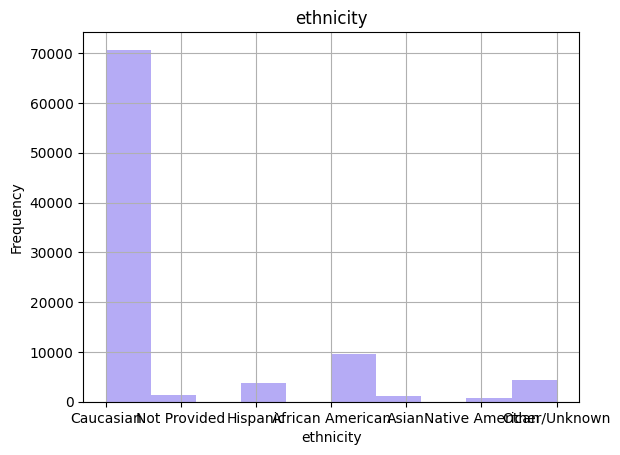

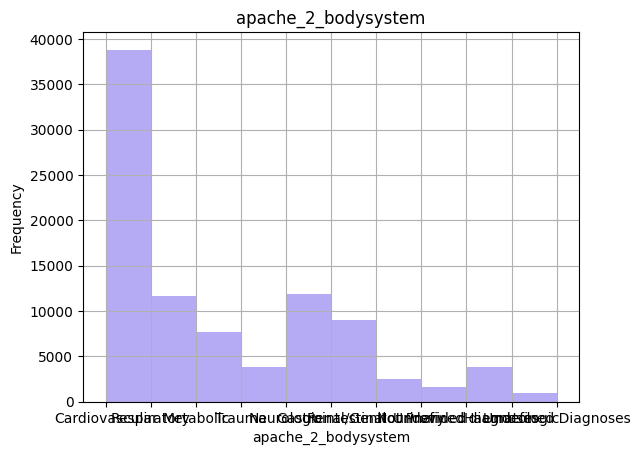

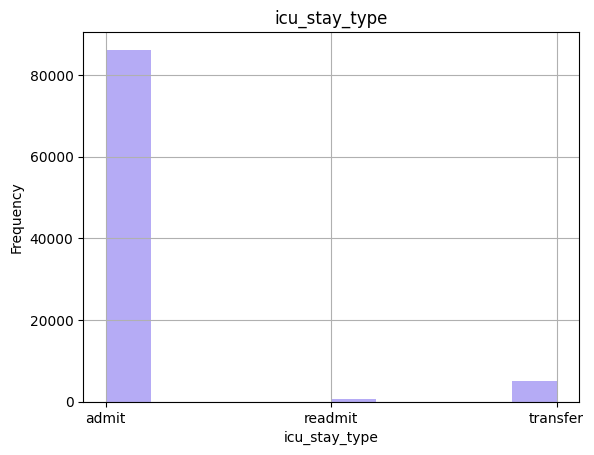

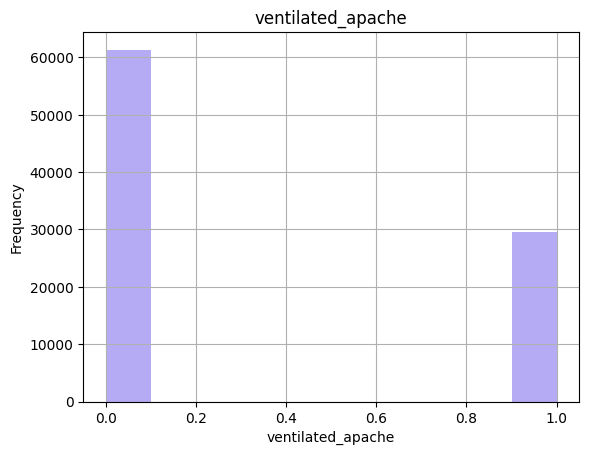

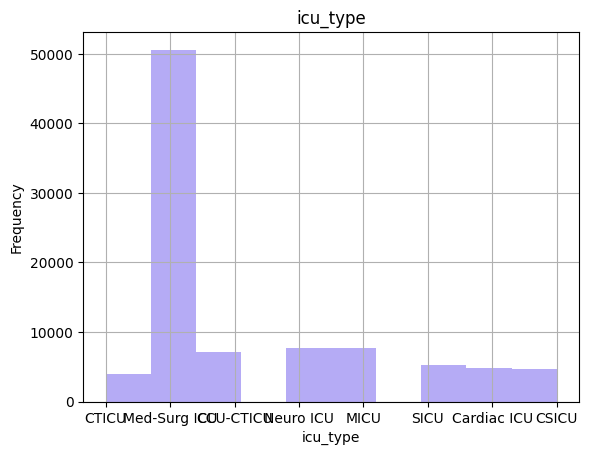

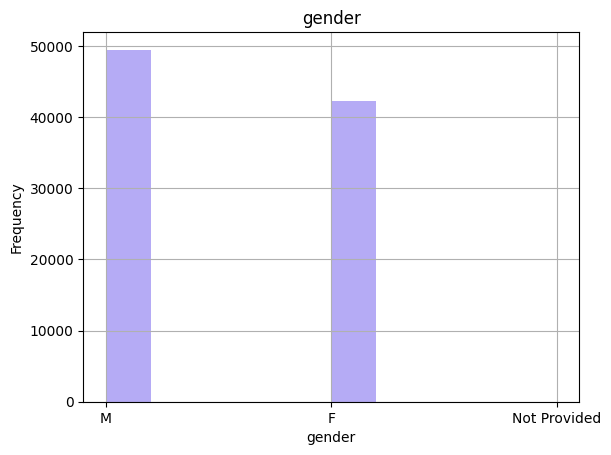

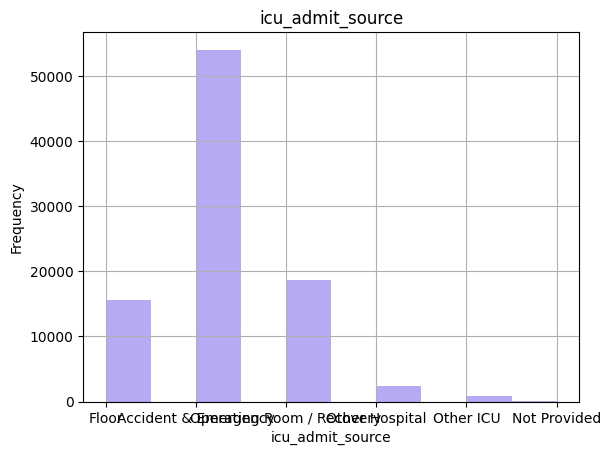

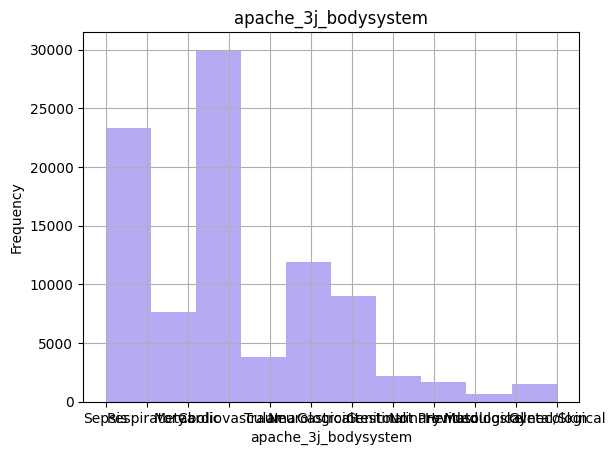

In [19]:
# Distribution of categorical features
for i in categorical_columns:
  # Create a histogram for the 'HDI for year' column with a custom color
  df_selected[i].hist(color='#b5abf5')  # Using a shade of blue as an example color
  plt.xlabel(i)  # Label for the x-axis
  plt.ylabel('Frequency')     # Label for the y-axis
  plt.title(i)  # Title for the histogram
  plt.show()  # Display the histogram

# Split Data

In [20]:
from sklearn.model_selection import train_test_split

data = df_selected

# Randomly sample 70% of the data for training
training_data = data.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
testing_data = data.drop(training_data.index)

# Check the mean of the 'hospital_death' column in both training and testing data
print(training_data['hospital_death'].mean())
print(testing_data['hospital_death'].mean())

0.08616956650415115
0.086610452860362


In [21]:
# Data Preparation

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = training_data['hospital_death'].to_numpy()
Y_test = testing_data['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = training_data.drop('hospital_death', axis=1).to_numpy()
X_test = testing_data.drop('hospital_death', axis=1).to_numpy()

X_train1 = pd.DataFrame(X_train, columns=training_data.drop('hospital_death', axis=1).columns)
X_test1 = pd.DataFrame(X_test, columns=testing_data.drop('hospital_death', axis=1).columns)

# Imputation for training data & testing data

In [22]:
# Check missing values for training
missing_val = training_data.isnull().sum()
print(missing_val)

d1_spo2_min                  238
ethnicity                      0
apache_2_bodysystem            0
gcs_motor_apache            1320
gcs_verbal_apache           1320
d1_temp_min                 1609
icu_stay_type                  0
d1_sysbp_min                 109
hospital_death                 0
ventilated_apache            503
gcs_eyes_apache             1320
icu_type                       0
gender                         0
icu_admit_source               0
d1_sysbp_noninvasive_min     726
apache_3j_bodysystem           0
dtype: int64


In [23]:
# missing values & numerical data imputation
# imput with median
for i in numerical_columns:
  training_data[i].fillna(training_data[i].median(), inplace=True)
missing_val = training_data.isnull().sum()
print(missing_val)

d1_spo2_min                   0
ethnicity                     0
apache_2_bodysystem           0
gcs_motor_apache              0
gcs_verbal_apache             0
d1_temp_min                   0
icu_stay_type                 0
d1_sysbp_min                  0
hospital_death                0
ventilated_apache           503
gcs_eyes_apache               0
icu_type                      0
gender                        0
icu_admit_source              0
d1_sysbp_noninvasive_min      0
apache_3j_bodysystem          0
dtype: int64


In [24]:
#drop rows with missing data
training_data=training_data.dropna()
missing_val = training_data.isnull().sum()
print(missing_val)

d1_spo2_min                 0
ethnicity                   0
apache_2_bodysystem         0
gcs_motor_apache            0
gcs_verbal_apache           0
d1_temp_min                 0
icu_stay_type               0
d1_sysbp_min                0
hospital_death              0
ventilated_apache           0
gcs_eyes_apache             0
icu_type                    0
gender                      0
icu_admit_source            0
d1_sysbp_noninvasive_min    0
apache_3j_bodysystem        0
dtype: int64


In [25]:
# Check missing values for testing
missing_val = testing_data.isnull().sum()
print(missing_val)

d1_spo2_min                  95
ethnicity                     0
apache_2_bodysystem           0
gcs_motor_apache            581
gcs_verbal_apache           581
d1_temp_min                 715
icu_stay_type                 0
d1_sysbp_min                 50
hospital_death                0
ventilated_apache           212
gcs_eyes_apache             581
icu_type                      0
gender                        0
icu_admit_source              0
d1_sysbp_noninvasive_min    301
apache_3j_bodysystem          0
dtype: int64


In [26]:
# missing values & numerical data imputation
for i in numerical_columns:
  testing_data[i].fillna(testing_data[i].median(), inplace=True)
missing_val = testing_data.isnull().sum()
print(missing_val)

d1_spo2_min                   0
ethnicity                     0
apache_2_bodysystem           0
gcs_motor_apache              0
gcs_verbal_apache             0
d1_temp_min                   0
icu_stay_type                 0
d1_sysbp_min                  0
hospital_death                0
ventilated_apache           212
gcs_eyes_apache               0
icu_type                      0
gender                        0
icu_admit_source              0
d1_sysbp_noninvasive_min      0
apache_3j_bodysystem          0
dtype: int64


In [27]:
#drop rows with missing data
testing_data=testing_data.dropna()
missing_val = testing_data.isnull().sum()
print(missing_val)

d1_spo2_min                 0
ethnicity                   0
apache_2_bodysystem         0
gcs_motor_apache            0
gcs_verbal_apache           0
d1_temp_min                 0
icu_stay_type               0
d1_sysbp_min                0
hospital_death              0
ventilated_apache           0
gcs_eyes_apache             0
icu_type                    0
gender                      0
icu_admit_source            0
d1_sysbp_noninvasive_min    0
apache_3j_bodysystem        0
dtype: int64


# Using Neural Networks

In [ ]:
# Label Encoding
df['gender'].replace({"M" : 0, "F" : 1}, inplace=True)
print(df['gender'].unique())

[ 0.  1. nan]


In [ ]:
#!pip install torch

# importing torch as t
import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout


In [ ]:
data = df_selected
data.columns

Index(['d1_temp_min', 'gender', 'icu_type', 'd1_sysbp_noninvasive_min',
       'apache_2_bodysystem', 'hospital_death', 'gcs_motor_apache',
       'd1_spo2_min', 'd1_sysbp_min', 'gcs_verbal_apache', 'gcs_eyes_apache',
       'ethnicity', 'ventilated_apache', 'icu_admit_source',
       'apache_3j_bodysystem', 'icu_stay_type'],
      dtype='object')

In [ ]:
# Data Preparation

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = training_data['hospital_death'].to_numpy()
Y_test = testing_data['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = training_data.drop('hospital_death', axis=1).to_numpy()
X_test = testing_data.drop('hospital_death', axis=1).to_numpy()

X_train1 = pd.DataFrame(X_train, columns=training_data.drop('hospital_death', axis=1).columns)
X_test1 = pd.DataFrame(X_test, columns=testing_data.drop('hospital_death', axis=1).columns)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_data_standardized = scaler.fit_transform(X_train1[numerical_columns])
a = pd.DataFrame(numerical_data_standardized, columns = numerical_columns)

encoder = TargetEncoder()
categorical_data_encoded = encoder.fit_transform(X_train1[categorical_columns], Y_train)
categorical_data_standardized = scaler.fit_transform(X_train1[numerical_columns])
b = pd.DataFrame(categorical_data_encoded, columns = categorical_columns)

X_train = a.join(b).values

In [ ]:
scaler = StandardScaler()
numerical_data_standardized = scaler.fit_transform(X_test1[numerical_columns])
c = pd.DataFrame(numerical_data_standardized, columns = numerical_columns)

encoder = TargetEncoder()
categorical_data_encoded = encoder.fit_transform(X_test1[categorical_columns], Y_test)
categorical_data_standardized = scaler.fit_transform(categorical_data_encoded)
d = pd.DataFrame(categorical_data_standardized, columns = categorical_columns)

X_test = c.join(d).values

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 15
number_of_hidden_units = 5
epochs = 1000
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Epoch 0/1000 ---> Train Accuracy: 0.9195553660392761, Validation Accuracy: 0.9187971353530884
Epoch 1/1000 ---> Train Accuracy: 0.9176400303840637, Validation Accuracy: 0.9153541922569275
Epoch 2/1000 ---> Train Accuracy: 0.9192256927490234, Validation Accuracy: 0.9173320531845093
Epoch 3/1000 ---> Train Accuracy: 0.9193198680877686, Validation Accuracy: 0.9171489477157593
Epoch 4/1000 ---> Train Accuracy: 0.9177813529968262, Validation Accuracy: 0.9151344299316406
Epoch 5/1000 ---> Train Accuracy: 0.9185976982116699, Validation Accuracy: 0.913119912147522
Epoch 6/1000 ---> Train Accuracy: 0.9167765378952026, Validation Accuracy: 0.9162698984146118
Epoch 7/1000 ---> Train Accuracy: 0.916933536529541, Validation Accuracy: 0.9158669710159302
Epoch 8/1000 ---> Train Accuracy: 0.9174516201019287, Validation Accuracy: 0.916086733341217
Epoch 9/1000 ---> Train Accuracy: 0.9194768667221069, Validation Accuracy: 0.9142187237739563
Epoch 10/1000 ---> Train Accuracy: 0.9176243543624878, Validati

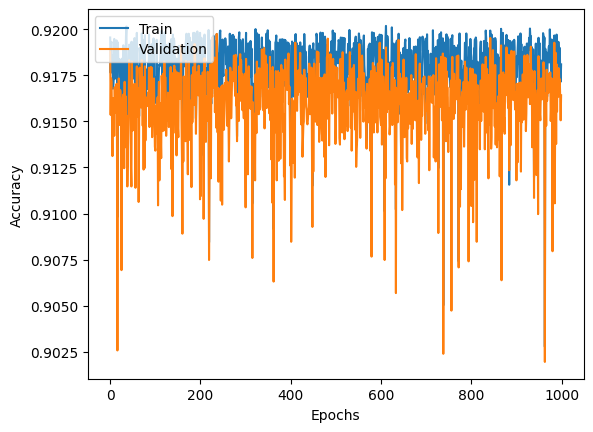

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Random Forest

In [28]:
#import libraries

#!pip install category_encoders

import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [29]:
#variable encoding

# one hot encode categorical columns with few variables
categorical1 = ['icu_stay_type', 'gender', 'ventilated_apache']
# target encode categorical columns with many variables
categorical2 = [c for c in categorical_columns if c not in categorical1 and c != target_column]

print(categorical1)
print(categorical2)

['icu_stay_type', 'gender', 'ventilated_apache']
['ethnicity', 'apache_2_bodysystem', 'icu_type', 'icu_admit_source', 'apache_3j_bodysystem']


In [30]:
#create pipeline
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical1]),
                        ('target_encoder', TargetEncoder(), [c for c in categorical2])],
                       remainder='passthrough')

# Initialize a Random Forest classifier
# The criterion 'Gini' measures the quality of a split - may be better for imbalanced classes compare to entropy
# class_weight 'balanced_subsample' is used to handle imbalanced classes - death is imbalanced
# oob_score is set to True to use out-of-bag samples to estimate the generalization accuracy
random_forest = RandomForestClassifier(criterion='gini', class_weight='balanced_subsample', oob_score=True)

# Creating a pipeline which first applies the column transformer preprocessing, then fits the Random Forest model
model = Pipeline([
    ('pre_process', ct),
    ('random_forest', random_forest)
])

# Display the pipeline architecture
model


Pipeline(steps=[('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['icu_stay_type', 'gender',
                                                   'ventilated_apache']),
                                                 ('target_encoder',
                                                  TargetEncoder(),
                                                  ['ethnicity',
                                                   'apache_2_bodysystem',
                                                   'icu_type',
                                                   'icu_admit_source',
                                                   'apache_3j_bodysystem'])])),
                ('random_forest',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        oob_score=True))])

### Model training and evaluation

In [32]:
# using same training and test set as neural network model

# Using the pipeline model to train on the training data.
# Dropping the target column from the input features.
model = model.fit(training_data.drop('hospital_death', axis=1), training_data['hospital_death'])

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_pred = model.predict(training_data.drop('hospital_death', axis=1))
print(accuracy_score(training_data['hospital_death'], Y_pred))
#0.999

# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_pred = model.predict(testing_data.drop('hospital_death', axis=1))
print(accuracy_score(testing_data['hospital_death'], Y_pred))
#0.92
#quite high

0.9997017081135393
0.9199326056699143


In [33]:
# get initial parameters
params = random_forest.get_params()

# Print the parameters
print("Random Forest Initial Parameters:")
print(params)

#'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini'
#'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None
#'min_impurity_decrease': 0.0, 'min_samples_leaf': 1,'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0
#'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False

Random Forest Initial Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Hyperparameter tuning

In [34]:
# Setting hyperparameters for Random Forest for the Grid Search.
# informed by intitial model, since there was high accuracy
param_dist = {
    "random_forest__n_estimators" : [100],
    "random_forest__max_depth" : [5, 10, 15],
    "random_forest__min_samples_leaf" : [10, 20, 30],
    "random_forest__max_features" : ['sqrt', 8], #total features=15
    "random_forest__min_impurity_decrease" : [0, 0.01],
    "random_forest__bootstrap" : [True]
}

#waited 45 min then cut down on parameter options
#this takes 20 min

# Initializing stratified K-fold cross-validation. This ensures each fold has the same proportion of target labels as the whole dataset.
skf = StratifiedKFold(n_splits=5)

# Setting up GridSearchCV to search through the parameter space.
# It will evaluate the model for each combination of hyperparameters provided using stratified K-fold cross-validation.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data.
random_search.fit(training_data.drop('hospital_death', axis=1), training_data['hospital_death'])

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__bootstrap,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__min_impurity_decrease,param_random_forest__min_samples_leaf,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,9.881542,0.685603,0.255501,0.034889,True,15,8,0,10,100,"{'random_forest__bootstrap': True, 'random_for...",0.852747,0.860115,0.849203,0.858074,0.860586,0.856145,0.004448,1


In [35]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'random_forest__bootstrap': True,
 'random_forest__max_depth': 15,
 'random_forest__max_features': 8,
 'random_forest__min_impurity_decrease': 0,
 'random_forest__min_samples_leaf': 10,
 'random_forest__n_estimators': 100}

In [36]:
# Apply optimal hyperparameters
model = model.set_params(**random_search.best_params_)

# Retraining the model with the updated hyperparameters on the training data.
model = model.fit(training_data.drop('hospital_death', axis=1), training_data['hospital_death'])

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_pred = model.predict(training_data.drop('hospital_death', axis=1))
print(accuracy_score(training_data['hospital_death'], Y_pred))


# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_pred = model.predict(testing_data.drop('hospital_death', axis=1))
print(accuracy_score(testing_data['hospital_death'], Y_pred))

# why did it get worse :D

0.8865234865611655
0.8537469782433521


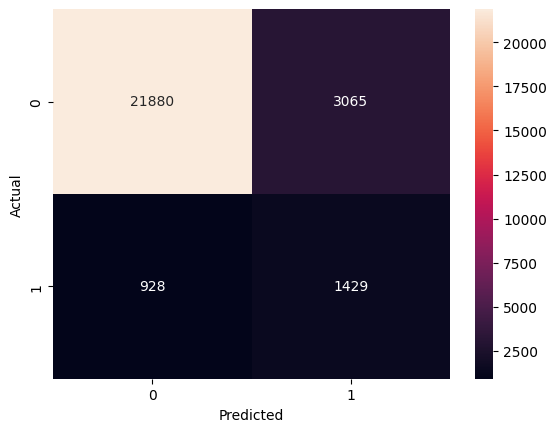

In [39]:
#confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
Y = testing_data['hospital_death']
conf_matrix = confusion_matrix(Y, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()